In [1]:
# %matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import pylops
from PIL import Image

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

sys.path.append('../')

from Dispersion.surfacewaves import *
from Dispersion.dispersionspectra import *
from Dispersion.inversion import *

import ccfj
import scipy
from Dispersion.Dispersion.dispersion import get_dispersion


def get_cpr(thick, vs, period):
    
    true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

    # Rayleigh-wave fundamental model dispersion curve 
    pd = PhaseDispersion(*true_model.T)
    cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]

    return cpr

def random_thick_vs(thick, vs, period, fluctuation_percentage=0.1):
    # 生成浮动值
    random_thick = thick * (1 + fluctuation_percentage * (2 * np.random.rand(len(thick)) - 1))
    random_vs = vs * (1 + fluctuation_percentage * (2 * np.random.rand(len(vs)) - 1))

    try:
        cpr = get_cpr(random_thick, random_vs, period)
        # plt.plot(1/cpr[0][0], cpr[0][1], 'k', lw=2, label='Original')
        return cpr
    except Exception as e:
        print(e)

def get_dshift(nt, dt, nx, dx, nfft, cpr):
    t, x = np.arange(nt)*dt, np.arange(nx)*dx

    # Wavelet
    wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
    wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

    # Data
    dshifts, fs, vfs = [], [], []
    for imode in range(3):
        dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                        np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
        dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
        fs.append(f_)
        vfs.append(vf_)
    dshift = np.concatenate(dshifts).sum(0)
    return dshift

In [19]:
fluctuation_percentage = 0.1

thick = np.array([0.01, 0.02, 0.03, 0.01])
vs = np.array([0.2, 0.4, 0.6, 0.8])

# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10


# Frequency axis
fdisp = np.linspace(3, 20, 301)

# Periods (must be sorted starting with low periods)
period = np.flipud(1/fdisp)

l1 = []
for i in range(50):
    cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)
    l1.append(np.flipud(cpr[0][1]))
# dshift = get_dshift(nt, dt, nx, dx, nfft, cpr)

(50, 301) (50, 301) (50, 301)


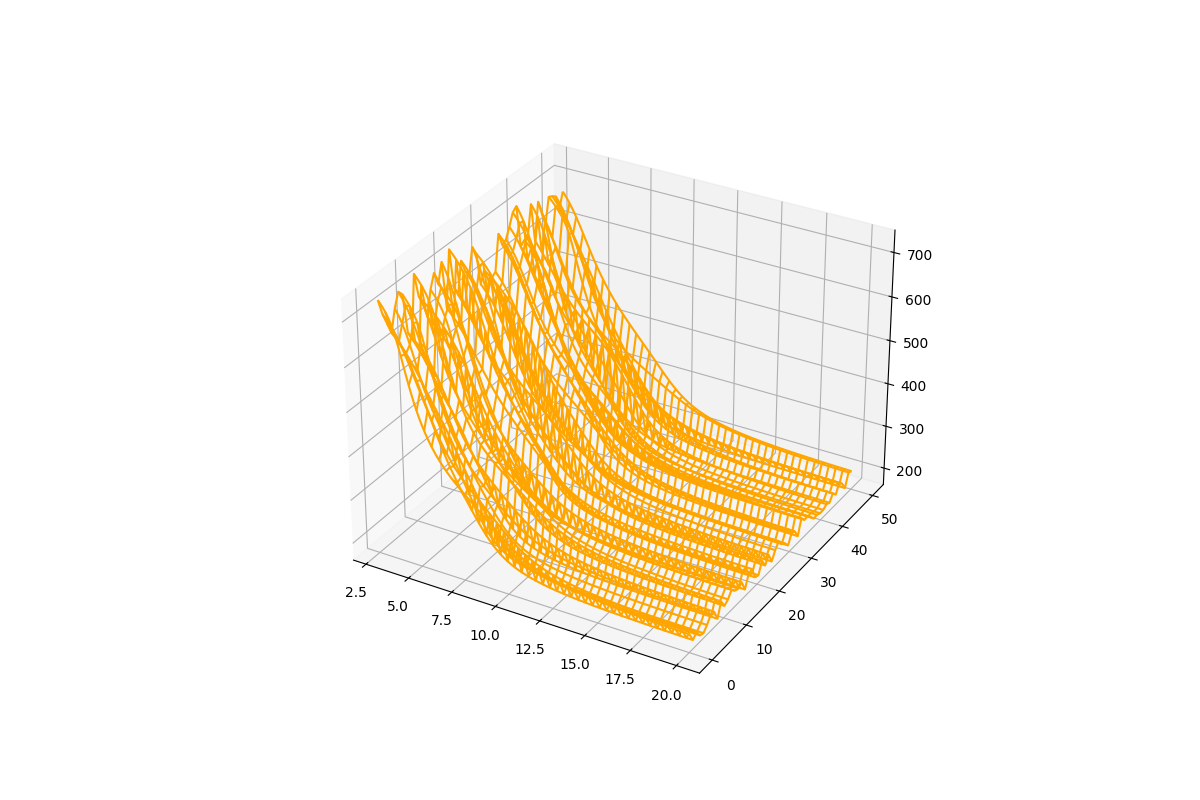

In [20]:
%matplotlib ipympl
x = fdisp
y = np.linspace(0, 50, 50)
Z = np.array(l1)*1000

X, Y = np.meshgrid(x, y)

print(X.shape, Y.shape, Z.shape)

# 创建3D图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制图像
ax.plot_wireframe(X, Y, Z, color='orange')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成数据
X = np.linspace(-100, 100, 100)
Y = np.linspace(-100, 100, 100)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2

# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制图像
ax.plot_wireframe(X, Y, Z)

# 设置标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图像
plt.show()
print(X.shape, Y.shape, Z.shape)